In [2]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [3]:
df = pd.read_csv("/Users/zenlabsmac4/Downloads/CreditCardFraud/creditcard.csv")
df.loc[df.Class == 0, 'Normal'] = 1
df.loc[df.Class == 1, 'Normal'] = 0
df = df.rename(columns={'Class': 'Fraud'})
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Fraud,Normal
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,1.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.0


In [4]:
print(df.Normal.value_counts())
print()
print(df.Fraud.value_counts())
Fraud = df[df.Fraud == 1]
Normal = df[df.Normal == 1]

1.0    284315
0.0       492
Name: Normal, dtype: int64

0    284315
1       492
Name: Fraud, dtype: int64


In [5]:

X_train = Fraud.sample(int(0.7*len(Fraud)))
count_Frauds = len(X_train)

X_train = pd.concat([X_train, Normal.sample(n = int(0.7*len(Normal)))], axis = 0)

X_test = df.loc[~df.index.isin(X_train.index)]

X_train = shuffle(X_train)
X_test = shuffle(X_test)

In [6]:
y_train = X_train.Fraud
y_train = pd.concat([y_train, X_train.Normal], axis=1)

y_test = X_test.Fraud
y_test = pd.concat([y_test, X_test.Normal], axis=1)

X_train = X_train.drop(['Fraud','Normal'], axis = 1)
X_test = X_test.drop(['Fraud','Normal'], axis = 1)

In [7]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

199364
199364
85443
85443


In [8]:
ratio = len(X_train)/count_Frauds 

y_train.Fraud *= ratio
y_test.Fraud *= ratio

In [9]:
features = X_train.columns.values

for feature in features:
    mean, std = df[feature].mean(), df[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std

In [10]:
inputX = X_train.as_matrix()
inputY = y_train.as_matrix()
inputX_test = X_test.as_matrix()
inputY_test = y_test.as_matrix()

In [12]:
mulitplier = 1.5 


hidden_nodes1 = 30
hidden_nodes2 = round(hidden_nodes1 * mulitplier)
hidden_nodes3 = round(hidden_nodes2 * mulitplier)

In [13]:
x = tf.placeholder(tf.float32, [None, 30]) #there are 30 inputs

#layer 1
W1 = tf.Variable(tf.zeros([30, hidden_nodes1]))
b1 = tf.Variable(tf.zeros([hidden_nodes1]))
y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

#layer 2
W2 = tf.Variable(tf.zeros([hidden_nodes1, hidden_nodes2]))
b2 = tf.Variable(tf.zeros([hidden_nodes2]))
y2 = tf.nn.sigmoid(tf.matmul(y1, W2) + b2)

#layer 3
W3 = tf.Variable(tf.zeros([hidden_nodes2, hidden_nodes3])) 
b3 = tf.Variable(tf.zeros([hidden_nodes3]))
y3 = tf.nn.sigmoid(tf.matmul(y2, W3) + b3)

#layer 4
W4 = tf.Variable(tf.zeros([hidden_nodes3, 2])) 
b4 = tf.Variable(tf.zeros([2]))
y4 = tf.nn.softmax(tf.matmul(y3, W4) + b4)

#output
y = y4
y_ = tf.placeholder(tf.float32, [None, 2])

In [14]:
learning_rate = 0.0005
training_epochs = 15000
display_step = 1000
n_samples = y_train.size

In [15]:
cost = tf.reduce_mean(tf.square(y_ - y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [16]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [17]:
accuracy_summary = []
cost_summary = [] 

for i in range(training_epochs):  
    sess.run([optimizer], feed_dict={x: inputX, y_: inputY})
    
    
    if (i) % display_step == 0:
        train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={x: inputX, y_: inputY})
        print ("Training step:", i,
               "Accuracy =", "{:.5f}".format(train_accuracy), 
               "Cost = ", "{:.5f}".format(newCost))
        accuracy_summary.append(train_accuracy)
        cost_summary.append(newCost)
        
print()
print ("Optimization Finished!")
training_accuracy = sess.run(accuracy, feed_dict={x: inputX, y_: inputY})
print ("Training Accuracy=", training_accuracy)
print()
predicted = tf.argmax(y, 1)
testing_accuracy, testing_predictions  = sess.run([accuracy,predicted], feed_dict={x: inputX_test, y_: inputY_test})
print ("Testing Accuracy=", testing_accuracy)

Training step: 0 Accuracy = 0.00173 Cost =  289.41812
Training step: 1000 Accuracy = 0.97010 Cost =  288.89542
Training step: 2000 Accuracy = 0.98267 Cost =  288.85452
Training step: 3000 Accuracy = 0.98601 Cost =  288.84265
Training step: 4000 Accuracy = 0.99010 Cost =  288.83795
Training step: 5000 Accuracy = 0.99262 Cost =  288.83563
Training step: 6000 Accuracy = 0.99421 Cost =  288.83444
Training step: 7000 Accuracy = 0.99533 Cost =  288.83374
Training step: 8000 Accuracy = 0.99639 Cost =  288.83310
Training step: 9000 Accuracy = 0.99702 Cost =  288.83286
Training step: 10000 Accuracy = 0.99730 Cost =  288.83264
Training step: 11000 Accuracy = 0.99756 Cost =  288.83246
Training step: 12000 Accuracy = 0.99771 Cost =  288.83240
Training step: 13000 Accuracy = 0.99785 Cost =  288.83228
Training step: 14000 Accuracy = 0.99792 Cost =  288.83221

Optimization Finished!
Training Accuracy= 0.997979

Testing Accuracy= 0.997413


In [19]:
predicted = tf.argmax(y, 1)
testing_accuracy, testing_predictions = sess.run([accuracy,predicted], feed_dict={x: inputX_test, y_: inputY_test })
print(testing_accuracy)
cm = confusion_matrix(y_test.Normal, testing_predictions)
print("RECALL SCORE",recall_score(y_test.Normal,testing_predictions))
print("PRECISION SCORE", precision_score(y_test.Normal,testing_predictions))

0.997413
RECALL SCORE 0.997666920687
PRECISION SCORE 0.99974153528


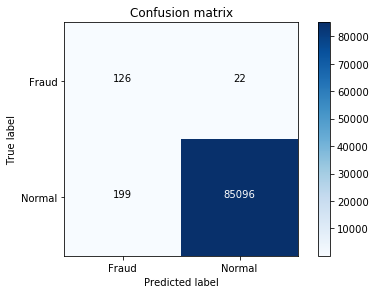

In [20]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names = ['Fraud','Normal']
plt.figure()
plot_confusion_matrix(cm
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

ax1.plot(accuracy_summary)
ax1.set_title('Accuracy')

ax2.plot(cost_summary)
ax2.set_title('Cost')

plt.xlabel('Epochs (x100)')
plt.show()